#- Notebook 2 after scraping clearance data


```python
!pip install PyMuPDF
!pip install fitz
!pip install jsonlines
!pip install pandas
!pip install tqdm
!pip install spacy
!python -m spacy download en_core_web_lg
! pip install seaborn               # statistical plots
! pip install association_metrics   # correlation/association & plot
! pip install dython                # Correlation/association & plot
! pip install pingouin              # Hypothesis testing
```

### Building a dataset using the clearance documents 
- What answers might we be able to ask with this new database? 
- We can extract things related to dates, times, and other things from the text (unstructured) and the structured data elements which we will generate by extracting things such as the adjudication guidelines, the presence of a lawyer, etc.

### Other questions we can investigate
1. What is the ratio of affirmed clearance denials to approvals granted upon appeal?
- What is the trend over time for the last few years?
2. What adjudicating factors, if any, are significantly correlated (either positively or negatively) with each other?
- a. What new insights, if any, can be gleaned by these relationships?
- b. What emergent features related to one or more adjudicating factors?
3. What hostile insider acts, if any, can be identified?
- a. How are these related to other adjudicating factors?
4. What is the impact of falsifications on the SF-86 on appeal outcomes?
- a. Is there a statistically significant correlation or causal relationship that can be quantified?
5. Are there best practices or guidance for industrial security practitioners, clearance applicants, and appellants that can be abstracted beyond the thirteen adjudicative guidelines?
6. Can we query and look for similar use-cases and understand why one was adjudicated and not the other

In [1]:
import re
import datetime
import requests
from bs4 import BeautifulSoup
import os
import seaborn as sns
import string
import glob
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from collections import defaultdict 
from pathlib import Path
import jsonlines
import ujson
import pandas as pd
import spacy
import numpy as np
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")
pd.options.plotting.backend = "plotly"

# adding simple warning filter
warnings.simplefilter('ignore')

from tqdm.notebook import tqdm_notebook

toeval = lambda x: eval(x) if isinstance(x, str) and x[0]=='[' else x
tolist = lambda x: x if isinstance(x, list) else (x if pd.isnull(x) else [x])


def term_in_val(val, term):
    if term in val:
        return True
    else:
        return False


def items_present_test(input_list, clist):
    """
    Check if any of the items in clist are in input_list
    :param input_list: a list to look for them in
    :param clist: things you're looking for
    :return:
    """
    return any(x in input_list for x in clist)



def cln(i, extent=1):
    """
    String white space 'cleaner'.
    :param i:
    :param extent: 1 --> all white space reduced to length 1; 2 --> removal of all white space.
    :return:
    """

    if isinstance(i, str) and i != "":
        if extent == 1:
            return re.sub(r"\s\s+", " ", i)
        elif extent == 2:
            return re.sub(r"\s+", "", i)
    else:
        return i



def partial_match(input_str, looking_for):
    """
    :param input_str:
    :param looking_for:
    :return:
    """

    if isinstance(input_str, str) and isinstance(looking_for, str):
        return cln(looking_for.lower(), 1) in cln(input_str.lower(), 1)
    else:
        return False


def normalize_dataframe(df, columns):
    """
    uses min max scaling
    :param df: pandas dataframe object
    :param columns: list of nominal features
    :return: scaled dataframe with column values processed with min max scaling
    """

    result = df.copy()
    for feature_name in columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


                
def NullUnique(df):
    dic = defaultdict(list)
    for col in df.columns:
        dic['Feature'].append(col)
        dic['NumUnique'].append(len(df[col].unique()))
        dic['NumNull'].append(df[col].isnull().sum())
        dic['%Null'].append(round(df[col].isnull().sum()/df.shape[0] * 100,2))


def get_match(text, rex):
    if isinstance(rex, (list, tuple, set)):
        rex = '(' + '|'.join(rex) + ')'
    result = re.findall(rex, text)
    return result


def unorder_dict(x):
    if isinstance(x, OrderedDict):
        return {k: unorder_dict(v) for k,v in x.items()}
    elif isinstance(x, list):
        return [unorder_dict(v) for v in x]
    else:
        return x

def isinList(val, list_):
    if val in list_:
        return 1
    else:
        return 0

def create_count_bucket(val):
    """creates bucket based on count"""
    if val > 0:
        return 1
    else:
        return 0


transtable = str.maketrans(dict.fromkeys(string.punctuation))

def to_string(s):
    """
    takes input s and returns a string type and encoding if necessary
    """
    try:
        return str(s)
    except:
        # Change the encoding type if needed
        return s.encode('utf-8')


def unicodeToAscii(s):
    """
    input: string
    output: string ascii
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        )


transtable = str.maketrans(dict.fromkeys(string.punctuation))


def strip_punctuation(input_string):
    """cleans string by stripping punctuation """
    return input_string.translate(transtable)



def chunks(l, n):
    """Yield n number of sequential chunks from l."""
    d, r = divmod(len(l), n)
    for i in range(n):
        si = (d + 1) * (i if i < r else r) + d * (0 if i < r else i - r)
        yield l[si:si + (d + 1 if i < r else d)]


flatten = lambda l: [item for sublist in l for item in sublist]

In [2]:
dir_path = 'ISCR_decisions/'

In [3]:
SECTIONS = [
    'Appearances',
    'Decision',
    'Statement of Case',
    'Findings of Fact',
    'Policies',
    'Analysis',
    'Whole-Person Concept',
    'Formal Findings',
    'Conclusion',
]

In [4]:
pdf_files = glob.glob(dir_path + '*.pdf')
print(len(pdf_files)) # 2476 files is pretty great! 

2476


```python
# # we're going to dump the results into a list and then write out to a data frame

results = []

for file in tqdm(pdf_files):
    
    # load the pdf and parse out the text
    with fitz.open(file) as doc:
        text = ""
        for page in doc:
            text += page.get_text()
         

    # clean up any page numbers
    # page numbers wrapped in a couple newlines and spaces
    pagenum_rex = r'(?:\n\s*?)\d+(?:\s*?\n\s*?)+'
    clean_text = re.sub(pagenum_rex, r'\n', text)
    
    
    # this will split each section based on the above keywords
    # we will get a list where it will alternate between the splitting text (section name) and the text following it (section text)
    section_rex = r'((?:\n\s*?)(?:' + '|'.join(SECTIONS) + ')(?:\s*?\n\s*?)+)'
    # note, we add 'Header' to designate all text before the first found section
    sections = ['Header'] + re.split(section_rex, clean_text)

    
    # now we can convert this to a dict
    # let's first create a dict with the pdf name info, and then add the parsed sections
    pdf_dict = {
        'filename' : file.split('/')[-1]
    }
    for i in range(0, len(sections), 2):
        section_name = sections[i].strip()
        section_text = sections[i+1].strip()
        pdf_dict[section_name] = section_text
        
#     with jsonlines.open(output_fid, mode='a') as writer:
#         writer.write(json.dumps(pdf_dict))
        
    results.append(pdf_dict)
```

```python
# dumped into a dataframe and save to excel
output_fid = 'ICSR_parsed_sections.xlsx'

df = pd.DataFrame(results)
df.to_excel(output_fid, index=False)
```

In [8]:
# let's test that it loads
output_fid = 'ICSR_parsed_sections.xlsx'
new_df = pd.read_excel(output_fid)
print(new_df.shape)
# let's take a look at 4 samples
new_df.sample(3)
# each row represents one file (one case) broken out into different sections, e.g., Header, Appearances, etc. 

(2476, 11)


,filename,Header,Appearances,Decision,Statement of Case,Findings of Fact,Policies,Analysis,Whole-Person Concept,Formal Findings,Conclusion
1611,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n______________ \n______________ \n DEPAR...,"For Government: Eric C. Price, Esquire, Depart...","GALES, Robert Robinson, Administrative Judge: ...",NaN,"In her response to the SOR, Applicant admitted...",The U.S. Supreme Court has recognized the subs...,"Guideline F, Financial Considerations \n \nThe...","Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...
1104,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE ...,"For Government: Michelle Tilford, Esq., Depart...","______________ \nKILMARTIN, Robert J., Adminis...",NaN,NaN,When evaluating an applicant’s suitability for...,"Guideline F, Financial Considerations \n \nThe...","Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...
871,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n D...,"For Government: Benjamin R. Dorsey, Esq., Depa...","______________ \nLOUGHRAN, Edward W., Administ...",NaN,Applicant is a 43-year-old potential employee ...,This case is adjudicated under Executive Order...,"Guideline B, Foreign Influence \n \n \nThe sec...","Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,It is clearly consistent with the national int...


## Building out the Dataset
- cleaning
- feature engineering
    - For the sake of convenience, we will apply some very simple rules looking for key words such as "denied" or "granted" to provide labels for the outcome
    - definitely in practice, we would want to go back and improve our labeling rules and would want to ensure that the outcomes are correct
    - We filter out the rows that do not have any extracted outcome
    
 - We add other features such as the number of Guidelines mentioned in Analysis, but to understand if there were postive or negative interactions of the adjudicative guidelines and the impact on outcome or how they effect each other - (either positively or negatively)- we would want to utilize the formal Findings (with Against and For) as another layer of features to be added to the analysis
     - other dates we extract include: - if the individual had representation , and the date of the Appearance
- Furthermore, because DCSA


In [9]:
def make_nptriue(dataframe):
    return np.triu(np.ones_like(dataframe.corr()))



In [10]:
new_df['Outcome'] = new_df['Conclusion'].map(lambda x: np.unique(get_match(str(x), ['denied', 'granted'])), na_action='ignore').map(lambda x: x[0].upper() if len(x) > 0 else None, na_action='ignore')
new_df

,filename,Header,Appearances,Decision,Statement of Case,Findings of Fact,Policies,Analysis,Whole-Person Concept,Formal Findings,Conclusion,Outcome
0,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE...,"For Government: Jeff Nagel, Esquire, Departmen...","______________ \nDAM, Shari, Administrative Ju...","On March 27, 2018, the Department of Defense (...",Applicant admitted all delinquent debts allege...,This case is adjudicated under Executive Order...,Guideline F: Financial Considerations \n \n \n...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...,GRANTED
1,doha.ogc.osd.mil_Industrial-Security-Program_I...,DEPARTMENT OF DEFENSE \n DEFENSE OFFICE OF HEA...,"For Government: Daniel F. Crowley, Esq., Depar...","___________ \n \nHARVEY, Mark, Administrative ...",NaN,"In Applicant’s SOR response, she admitted all ...",The U.S. Supreme Court has recognized the subs...,Financial Considerations \n \nAG ¶ 18 articula...,"Under the whole-person concept, the administra...",Formal findings For or Against Applicant on th...,In light of all of the circumstances presented...,DENIED
2,doha.ogc.osd.mil_Industrial-Security-Program_I...,"• \nii Ii \n. -~!ij--.-\n-\n.. -,~~,,.... -\n-...","For Government: Bryan Olmos, Department Couns...","CERVI, Gregg A., Administrative Judge \nThis ...",NaN,Applicant is a 30-year-old warehouse technicia...,“[N]o one has a ‘right’ to a security clearanc...,Guideline F: Financial Considerations \nThe s...,"Under AG ¶¶ 2(a), 2(c), and 2(d), the ultimate...",Formal findings for or against Applicant on t...,_______________________ \nI conclude that it ...,DENIED
3,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Adrienne Driskill, Esq., Depar...","GLENDON, John Bayard, Administrative Judge: \n...",NaN,Applicant’s personal information is extracted ...,“[N]o one has a ‘right’ to a security clearanc...,"Guideline K, Handling Protected Information,...",NaN,"Paragraph 1, Guideline K: \nAGAINST APPLIC...",I conclude that it is not clearly consistent w...,DENIED
4,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Aubrey De Angelis, Esq., Depar...","CEFOLA, Richard A., Administrative Judge: \nSt...",NaN,Applicant admitted to the allegations in SOR ¶...,When evaluating an applicant’s national securi...,Guideline F - Financial Considerations \nThe s...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...,GRANTED
...,...,...,...,...,...,...,...,...,...,...,...,...
2471,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Bryan Olmos, Esq., Department ...","LOUGHRAN, Edward W., Administrative Judge: \nA...",NaN,Applicant is a 24-year-old engineer employed ...,This case is adjudicated under Executive Order...,"Guideline B, Foreign Influence \nThe security ...","Under the whole-person concept, the admini...",Formal findings for or against Applicant on th...,It is clearly consistent with the national int...,GRANTED
2472,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE ...,"For Government: Ross Hyams, Esq., Department C...","______________ \nRICCIARDELLO, Carol G., Admin...",NaN,Applicant admitted all of the SOR allegations ...,When evaluating an applicant’s suitability for...,Guideline F: Financial Considerations \n \nThe...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...,DENIED
2473,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE OFFI...,"For Government: Moira Modzelewski, Esquire, De...","______________ \nHOGAN, Erin

In [11]:

r = re.compile(r'\d{2}[ /-](?:\d{2}|Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)[ /-]\d{4}')


new_df['AppearanceDate'] = new_df['Appearances'].map(lambda x: r.findall(x), na_action='ignore')
new_df['FileYear']=new_df['filename'].map(lambda x: get_match(str(x), ['_20\d\d'])[0].replace('_', ''))
new_df = new_df.rename(columns={col: col.replace(' ', '') for col in new_df.columns})
new_df['ForGov'] = new_df['Decision'].map(lambda x: strip_punctuation(str(x).split("Administrative Judge")[0]), na_action='ignore')
new_df['Status'] = new_df['Conclusion'].map(lambda x: get_match(str(x), ['denied', 'granted']), na_action='ignore').map(lambda x: x[0].upper() if len(x) > 0 else None, na_action='ignore')

display(new_df.sort_values('FileYear', ascending=False).applymap(cln).head())
t = pd.crosstab(new_df['Status'], new_df['FileYear']) # appeals over time


t.apply(sum, axis=0).to_frame()


,filename,Header,Appearances,Decision,StatementofCase,FindingsofFact,Policies,Analysis,Whole-PersonConcept,FormalFindings,Conclusion,Outcome,AppearanceDate,FileYear,ForGov,Status
2158,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ ______________ DEPARTMENT OF DE...,"For Government: Kelly Folks, Esq., Department ...","MURPHY, Braden M., Administrative Judge: Appli...",NaN,"In his Answer to the SOR, Applicant denied all...",It is well established that no one has a right...,"Guideline F, Financial Considerations The trus...","Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,"In light of all of the circumstances, presente...",GRANTED,[04/13/2022],2022,MURPHY Braden M,GRANTED
1221,doha.ogc.osd.mil_Industrial-Security-Program_I...,EA c; ... o _.~ .t::~!~ o ______________ _____...,"For Government: A. H. Henderson, Esq., Departm...","FOREMAN, LeRoy F., Administrative Judge: This ...",NaN,"In Applicant’s answer to the SOR, he admitted ...",“[N]o one has a ‘right’ to a security clearanc...,"Guideline F, Financial Considerations The secu...","Under AG ¶ 2(c), the ultimate determination of...",I make the following formal findings on the al...,I conclude that it is not clearly consistent w...,DENIED,[03/31/2022],2022,FOREMAN LeRoy F,DENIED
718,doha.ogc.osd.mil_Industrial-Security-Program_I...,___________ ___________ DEPARTMENT OF DEFENSE ...,"For Government: Raashid S. Williams, Esq., Dep...","HARVEY, Mark, Administrative Judge: Applicant ...",NaN,"In Applicant’s SOR response, he admitted the S...",The U.S. Supreme Court has recognized the subs...,Financial Considerations AG ¶ 18 articulates t...,"Under the whole-person concept, the administra...",Formal findings For or Against Applicant on th...,In light of all of the circumstances in this c...,DENIED,[01/31/2022],2022,HARVEY Mark,DENIED
721,doha.ogc.osd.mil_Industrial-Security-Program_I...,\\ EA c; ... o _.~ .t::~!~ o\n______________ _...,"For Government: David Hayes, Esq., Department ...","FOREMAN, LeRoy F., Administrative Judge: This ...",NaN,"In Applicant’s answer to the SOR, he admitted ...",“[N]o one has a ‘right’ to a security clearanc...,"Guideline J, Criminal Conduct The SOR alleges ...","Under AG ¶ 2(c), the ultimate determination of...",I make the following formal findings on the al...,I conclude that it is clearly consistent with ...,GRANTED,[03/01/2022],2022,FOREMAN LeRoy F,GRANTED
2328,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ ______________ DEPARTMENT OF DE...,"For Government: Rhett Petcher, Esq., Departmen...","HYAMS, Ross D., Administrative Judge: Applican...",NaN,"In his Answer, Applicant admitted SOR ¶¶ 1.a –...",This case is adjudicated under Executive Order...,"Guideline F, Financial Considerations The secu...","Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,It is not clearly consistent with the national...,DENIED,[04/04/2022],2022,HYAMS Ross D,DENIED


,0
FileYear,
2019,1089
2020,444
2021,594
2022,243


In [12]:
adjud = pd.read_csv('adjudicativeguideline.txt', delimiter=':')
adjud['LETTER'] = adjud[' GUIDELINE'].map(lambda x: x.split(' ')[-1])
adjud[' DEFINITION'] = adjud[' DEFINITION'].map(lambda x: x.strip())
letter2definition = adjud.set_index('LETTER')[' DEFINITION'].to_dict()
adjud['GUIDELINE'] = adjud[' GUIDELINE'].map(lambda x: 'Guideline ' + x.split(' ')[-1])
letter2guideline = adjud.set_index('LETTER')['GUIDELINE'].to_dict()



extracted_guidelines = new_df['Analysis'].map(lambda x: get_match(cln(str(x).replace('\n', ' ')), rex=list(letter2guideline.values()) + list(letter2definition.values())))
extracted_guidelines = extracted_guidelines.rename('text').to_frame()

lbl_map = {**adjud.set_index('GUIDELINE').LETTER.to_dict(),
           **adjud.set_index(' DEFINITION').LETTER.to_dict()}

def get_lbls(lst, dct):
    results = []
    for l in lst:       
        results += [v for k,v in lbl_map.items() if k.lower().strip() in cln(str(l).lower().replace('\n', ' '))]
    return set(results)

extracted_guidelines['labels'] = extracted_guidelines['text'].map(lambda x: get_lbls(x, lbl_map))

extracted_guidelines = extracted_guidelines.merge((extracted_guidelines.labels.map(lambda x: x if x!=set() else set(['null'])).explode().to_frame()
                                                   .assign(val=1).pivot(columns=['labels'], values=['val']).fillna(0).val),
                                                  left_index=True, right_index=True, how='outer'
                                                 )

In [13]:
print(extracted_guidelines.null.value_counts())
# about 7% of the data
print(adjud.columns)

0.0    2292
1.0     184
Name: null, dtype: int64
Index(['COL1', ' GUIDELINE', ' DEFINITION', 'LETTER', 'GUIDELINE'], dtype='object')


In [14]:
adictionary_ = adjud.set_index(['LETTER'])[' DEFINITION'].to_dict()
adictionary_

{'A': 'Allegiance to the United States',
 'B': 'Foreign Influence',
 'C': 'Foreign Preference',
 'D': 'Sexual Behavior',
 'E': 'Personal Conduct',
 'F': 'Financial Considerations',
 'G': 'Alcohol Consumption',
 'H': 'Drug Involvement',
 'I': 'Psychological Conditions',
 'J': 'Criminal Conduct',
 'K': 'Handling Protected Information',
 'L': 'Outside Activities',
 'M': 'Use of Information Technology Systems'}

In [15]:
mergeddf = new_df.merge(extracted_guidelines, left_index=True, right_index=True, how='outer')
mergeddf

,filename,Header,Appearances,Decision,StatementofCase,FindingsofFact,Policies,Analysis,Whole-PersonConcept,FormalFindings,...,E,F,G,H,I,J,K,L,M,null
0,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE...,"For Government: Jeff Nagel, Esquire, Departmen...","______________ \nDAM, Shari, Administrative Ju...","On March 27, 2018, the Department of Defense (...",Applicant admitted all delinquent debts allege...,This case is adjudicated under Executive Order...,Guideline F: Financial Considerations \n \n \n...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,doha.ogc.osd.mil_Industrial-Security-Program_I...,DEPARTMENT OF DEFENSE \n DEFENSE OFFICE OF HEA...,"For Government: Daniel F. Crowley, Esq., Depar...","___________ \n \nHARVEY, Mark, Administrative ...",NaN,"In Applicant’s SOR response, she admitted all ...",The U.S. Supreme Court has recognized the subs...,Financial Considerations \n \nAG ¶ 18 articula...,"Under the whole-person concept, the administra...",Formal findings For or Against Applicant on th...,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,doha.ogc.osd.mil_Industrial-Security-Program_I...,"• \nii Ii \n. -~!ij--.-\n-\n.. -,~~,,.... -\n-...","For Government: Bryan Olmos, Department Couns...","CERVI, Gregg A., Administrative Judge \nThis ...",NaN,Applicant is a 30-year-old warehouse technicia...,“[N]o one has a ‘right’ to a security clearanc...,Guideline F: Financial Considerations \nThe s...,"Under AG ¶¶ 2(a), 2(c), and 2(d), the ultimate...",Formal findings for or against Applicant on t...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Adrienne Driskill, Esq., Depar...","GLENDON, John Bayard, Administrative Judge: \n...",NaN,Applicant’s personal information is extracted ...,“[N]o one has a ‘right’ to a security clearanc...,"Guideline K, Handling Protected Information,...",NaN,"Paragraph 1, Guideline K: \nAGAINST APPLIC...",...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Aubrey De Angelis, Esq., Depar...","CEFOLA, Richard A., Administrative Judge: \nSt...",NaN,Applicant admitted to the allegations in SOR ¶...,When evaluating an applicant’s national securi...,Guideline F - Financial Considerations \nThe s...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Bryan Olmos, Esq., Department ...","LOUGHRAN, Edward W., Administrative Judge: \nA...",NaN,Applicant is a 24-year-old engineer employed ...,This case is adjudicated under Executive Order...,"Guideline B, Foreign Influence \nThe security ...","Under the whole-person concept, the admini...",Formal findings for or against Applicant on th...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE ...,"For Government: Ross Hyams, Esq., Department C...","______________ \nRICCIARDELLO, Carol G., Admin...",NaN,Applicant admitted all of the SOR allegations ...,When evaluating an applicant’s suitability for...,Guideline F: Financial Considerations \n \nThe...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE OFFI...,"For Government: Moira Modzelewski, Esquire, De...","______________ \nHOGAN, Erin C., Administrativ...",NaN,Applicant is a 56-year-old p

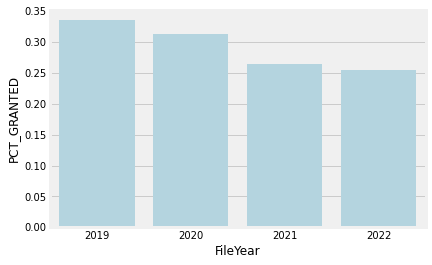

In [16]:
dfyear = pd.crosstab(mergeddf['FileYear'], mergeddf['Outcome']).reset_index()
dfyear['PCT_GRANTED'] = dfyear['GRANTED'] / (dfyear['GRANTED'] + dfyear['DENIED'])
dfyear_melt = pd.melt(dfyear, id_vars=['FileYear'], value_vars=['DENIED', 'GRANTED'])

ax = sns.barplot(data=dfyear, x='FileYear', y='PCT_GRANTED', color='lightblue') # decreased about 7 % over the years -- decrease in submissions but 

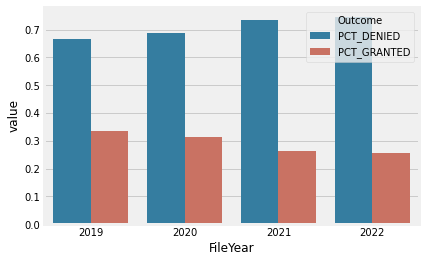

In [17]:

dfyear['PCT_DENIED'] = dfyear['DENIED'] / (dfyear['GRANTED'] + dfyear['DENIED'])
dfpctgranted = pd.melt(dfyear, id_vars=['FileYear'], value_vars=['PCT_DENIED', 'PCT_GRANTED'])

ax = sns.barplot(x="FileYear", y="value", hue='Outcome', data=dfpctgranted, saturation=.5) # trend in decrease of percentage denied

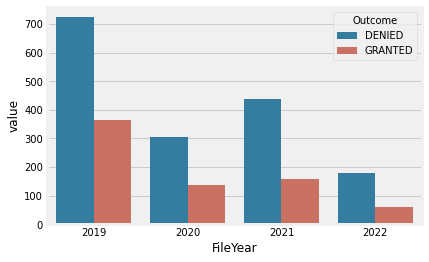

In [18]:
ax = sns.barplot(x="FileYear", y="value", hue='Outcome', data=dfyear_melt, saturation=.5) # We do over the last couple of years there has been a decrease in the hearings processed/ appeals in the database

In [40]:
mergeddf['NumGuidelines'] = mergeddf.labels.map(list).map(len)
mergeddf['ForApplicant'] = mergeddf['Appearances'].map(lambda x: cln(x.split('For Applicant:')[-1].split('\n')[0].strip().upper()), na_action='ignore')
mergeddf['Representation'] = mergeddf['ForApplicant'].map(lambda x: 0 if 'PRO' in x else 1, na_action='ignore')

In [45]:
mergeddf['FY'] = mergeddf.FileYear.map(int)
mergeddf.describe().columns

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'null',
       'NumGuidelines', 'Representation', 'FY'],
      dtype='object')

How do we develop AI/ML/DS systems that  help make decisions leading to fair and equitable outcomes?
With the continued use of systems and pre-defined databases, there is a risk that someone may automatically be perceived as 
The criteria for fail/pass maybe biased towards certain group that has social/economic advantages (measurement bias)
We are improving our clearance process to be less biased, i.e., DCSA has a commitment to EEO groups


In [46]:
droppeddf = mergeddf[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'null',
       'NumGuidelines', 'Representation', 'FY','Outcome']].dropna()
print(mergeddf.shape)
print(droppeddf.shape)

(2476, 36)
(2349, 18)


In [47]:
print(mergeddf['Outcome'].value_counts())


DENIED     1647
GRANTED     723
Name: Outcome, dtype: int64


In [48]:
X = mergeddf[['FileYear', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'H', 'I', 'J', 'K', 'L', 'M',]]

y = mergeddf['Outcome'].map(lambda x: 0 if str(x).upper().strip()!= 'GRANTED' else 1 )

In [50]:
mergeddf['OUTCOME'] = y

numdf = mergeddf[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'null',
       'NumGuidelines', 'Representation', 'FY',    'OUTCOME']]
numdf = numdf.rename(columns={col: adictionary_.get(col, col) for col in numdf.columns })
numdf

,Allegiance to the United States,Foreign Influence,Foreign Preference,Sexual Behavior,Personal Conduct,Financial Considerations,Alcohol Consumption,Drug Involvement,Psychological Conditions,Criminal Conduct,Handling Protected Information,Outside Activities,Use of Information Technology Systems,null,NumGuidelines,Representation,FY,OUTCOME
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2019,1
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,2020,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2021,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,1.0,2021,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2021,1
2472,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2019,0
2473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,2019,0
2474,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,2019,0


In [51]:
mergeddf['NumGuidelines'] = mergeddf['labels'].map(list).map(len)
mergeddf

,filename,Header,Appearances,Decision,StatementofCase,FindingsofFact,Policies,Analysis,Whole-PersonConcept,FormalFindings,...,J,K,L,M,null,NumGuidelines,ForApplicant,Representation,FY,OUTCOME
0,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE...,"For Government: Jeff Nagel, Esquire, Departmen...","______________ \nDAM, Shari, Administrative Ju...","On March 27, 2018, the Department of Defense (...",Applicant admitted all delinquent debts allege...,This case is adjudicated under Executive Order...,Guideline F: Financial Considerations \n \n \n...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,...,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2019,1
1,doha.ogc.osd.mil_Industrial-Security-Program_I...,DEPARTMENT OF DEFENSE \n DEFENSE OFFICE OF HEA...,"For Government: Daniel F. Crowley, Esq., Depar...","___________ \n \nHARVEY, Mark, Administrative ...",NaN,"In Applicant’s SOR response, she admitted all ...",The U.S. Supreme Court has recognized the subs...,Financial Considerations \n \nAG ¶ 18 articula...,"Under the whole-person concept, the administra...",Formal findings For or Against Applicant on th...,...,0.0,0.0,0.0,0.0,0.0,2,"DANIEL P. MEYER, ESQ.",1.0,2020,0
2,doha.ogc.osd.mil_Industrial-Security-Program_I...,"• \nii Ii \n. -~!ij--.-\n-\n.. -,~~,,.... -\n-...","For Government: Bryan Olmos, Department Couns...","CERVI, Gregg A., Administrative Judge \nThis ...",NaN,Applicant is a 30-year-old warehouse technicia...,“[N]o one has a ‘right’ to a security clearanc...,Guideline F: Financial Considerations \nThe s...,"Under AG ¶¶ 2(a), 2(c), and 2(d), the ultimate...",Formal findings for or against Applicant on t...,...,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2021,0
3,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Adrienne Driskill, Esq., Depar...","GLENDON, John Bayard, Administrative Judge: \n...",NaN,Applicant’s personal information is extracted ...,“[N]o one has a ‘right’ to a security clearanc...,"Guideline K, Handling Protected Information,...",NaN,"Paragraph 1, Guideline K: \nAGAINST APPLIC...",...,0.0,1.0,0.0,1.0,0.0,3,"PHILLIP STACKHOUSE, ESQ.",1.0,2021,0
4,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Aubrey De Angelis, Esq., Depar...","CEFOLA, Richard A., Administrative Judge: \nSt...",NaN,Applicant admitted to the allegations in SOR ¶...,When evaluating an applicant’s national securi...,Guideline F - Financial Considerations \nThe s...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,...,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Bryan Olmos, Esq., Department ...","LOUGHRAN, Edward W., Administrative Judge: \nA...",NaN,Applicant is a 24-year-old engineer employed ...,This case is adjudicated under Executive Order...,"Guideline B, Foreign Influence \nThe security ...","Under the whole-person concept, the admini...",Formal findings for or against Applicant on th...,...,0.0,0.0,0.0,0.0,0.0,1,"LANCE RENFRO, ESQ.",1.0,2021,1
2472,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE ...,"For Government: Ross Hyams, Esq., Department C...","______________ \nRICCIARDELLO, Carol G., Admin...",NaN,Applicant admitted all of the SOR allegations ...,When evaluating an applicant’s suitability for...,Guideline F: Financial Considerations \n \nThe...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,...,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2019,0
2473,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE OFFI...,"For Government: Moira Modzelewski, Esquir

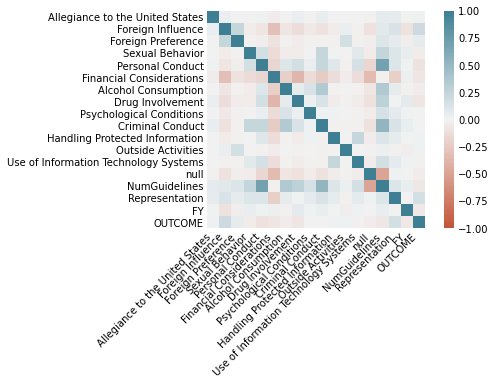

In [52]:
import seaborn as sns

corr = numdf.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

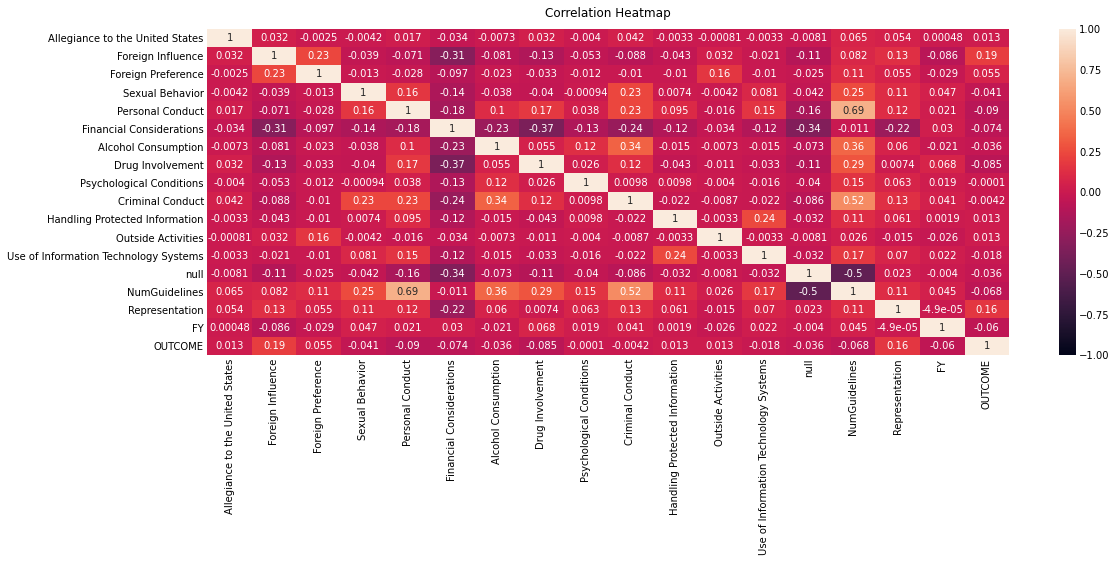

In [53]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(numdf.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

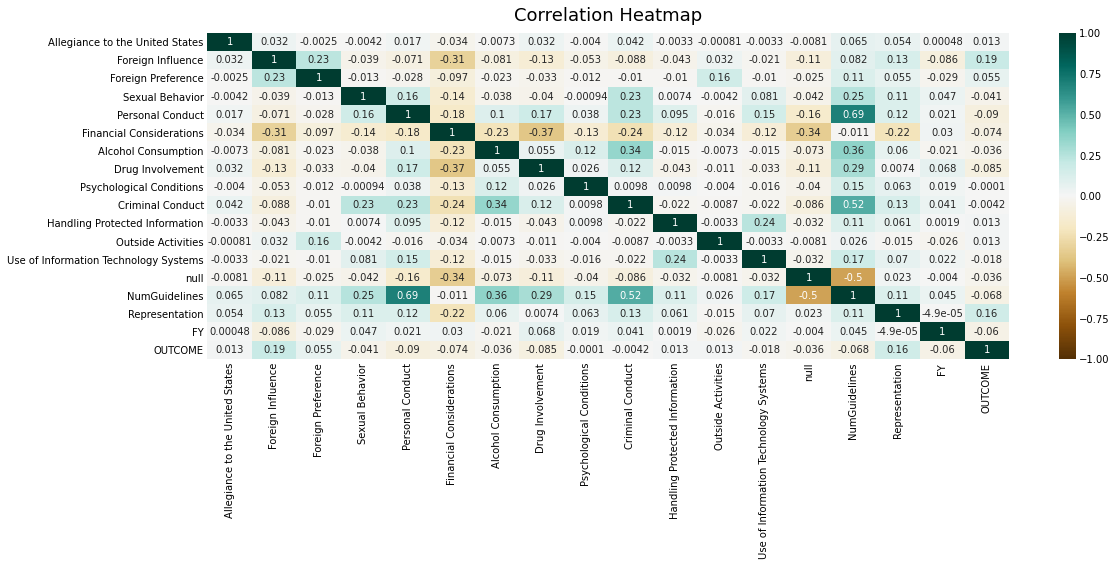

In [55]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(numdf.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap-association-acrossDCSAdataset.png', dpi=300, bbox_inches='tight')

In [56]:
numdf.corr()[['OUTCOME']].sort_values('OUTCOME', ascending=False)

,OUTCOME
OUTCOME,1.000000
Foreign Influence,0.192316
Representation,0.157198
Foreign Preference,0.055496
Handling Protected Information,0.013023
Allegiance to the United States,0.013007
Outside Activities,0.013007
Psychological Conditions,-0.000104
Criminal Conduct,-0.004211
Use of Information Technology Systems,-0.018435



Approximately 29% of applicants that committed domestic violence were granted a clearance, which is in keeping with the trend in the overall sample. However, applicants with a military background account for 3% of all cases, but 8.5% of incidents of domestic violence. Ergo, military applicants are over-represented in instances of domestic violence. Domestic violence in these scenarios could be indicative of undiagnosed combat stress or post-traumatic stress disorder (Lawrence, 2016). The Bureau of Labor Statistics (2016) identified 500 incidents of workplace homicides in 2016, with coworkers or work associates responsible for killing approximately 13 women and 53 men, with “relatives or domestic partners [as] the most frequent assailant in work-related homicides involving women.” Not only does employee-on-employee violence impact organizations, but the violence perpetrated by an employee’s former or current partner. If we want to help employees keep their clearances and keep the workforce safe, then warning signs for being the perpetrator (or victim) of domestic violence should be incorporated into facility security programs and EAPs to help prevent violence from escalating.




In [ ]:
Pricing Change 1 – 2020 Pay Raise: Reflects the costs to support the 2020 enacted 3.1% pay increase in FY 2021. This includes one quarter of
funding for Calendar Year 2020 and three quarters of funding for Calendar Year 2021.
Pricing Change 2 – 2021 Pay Raise: This pricing change reflects the impact of a 1.0% pay increase in Calendar Year 2021.
Pricing Change 3 – AMOC Systems and Information Sharing: Reflects the non-recur of the AMOC Systems and Information Sharing
enhancement included in the FY 2020 Enactment.
Pricing Change 4 – Adjustments to Prior Year Enactments: This adjustment incorporates changes attributed to the FY 2019 and FY 2020
Enactments. In general and unless otherwise specified, underfunded Administration priorities have been restored and Congressional additions have
been removed or reduced. Position and FTE data associated with this change have been incorporated in the “Rebaseline Workforce” program
change.
Pricing Change 5 – Adjustments to Prior Year Programming Base: Reflects an adjustment to align the current services base of the FY 2019
President’s Budget with the FY 2019 Enactment. Position and FTE data associated with this change have been incorporated in the “Rebaseline
Workforce” program change.
Pricing Change 6 – Annualization of FY 2020 9mm Weapons Transition Hiring: Reflects the annualization of the 9mm Weapons Transition
Hiring enhancement in the FY 2020 Enactment.  
U.S. Customs and Border Protection Operations and Support
CBP – OS - 23
Pricing Change 7 – Annualization of FY 2020 Counter Intelligence and Insider Threat: Reflects the annualization of the Counter Intelligence
and Insider Threat hiring enhancement included in the FY 2020 Enactment.
Pricing Change 8 – Annualization of FY 2020 National Vetting Center Hiring: Reflects the annualization of the National Vetting Center Hiring
enhancement in the FY 2020 Enactment.
Pricing Change 9 – Annualization of FY 2020 OFO Staff Hiring: Reflects the annualization of the OFO Staffing hiring enhancement in the FY
2020 Enactment.
Pricing Change 10 – Annualization of FY 2020 TFTEA Implementation Hiring: Reflects the annualization of the Trade Facilitation and Trade
Enforcement Act Implementation Hiring enhancement in the FY 2020 Enactment.
Pricing Change 11 – Automated Commercial Environment (ACE): Reflects a cost savings due to projected lower sustainment costs.
Pricing Change 12 – Contract Efficiencies: Reflects a reduction associated with administrative contract savings for Enterprise Services.
Pricing Change 13 – Delay in Hiring: Reflects savings associated with an increase to the average length of time taken to backfill positions after
employees separate from CBP.
Pricing Change 14 - FERS Agency Contribution: Per OMB Circular A-11, agency FERS contributions will increase in FY 2021. The regular
FERS agency contribution will increase by 1.3% from 16.0% in FY 2020 to 17.3% in FY 2021. The Law Enforcement FERS agency contribution
will increase by 2.4% from 33.4 to 35.8%. The agency contribution amount for CSRS will not change.
Pricing Change 15 – FPS Fee Adjustment: This pricing change will be used to offset anticipated increases in Federal Protective Service (FPS) basic
security fees due to a change in the FPS basic security fee level and assessment model.
Pricing Change 16 - GSA Rent: Reflects increased costs associated with new occupancy agreements; amortized tenant improvements; and existing
occupancy agreements, including standard inflation/cost adjustments and items, such as above-standard services for CBPs 24/7 facilities.
Pricing Change 17 – Gordie Howe International Bridge Land Border Integration Equipment: Reflects the non-recur of one-time funding
received in the FY 2020 Enactment for the Gordie Howe International Bridge project.
Pricing Change 18 – Information & Incident Coordination Center: Reflects the non-recur of one-time funding associated with the Information &
Incident Coordination Center enhancement in the FY 2020 Enactment. 
U.S. Customs and Border Protection Operations and Support
CBP – OS - 24
Pricing Change 19 - Integrated Fixed Towers (IFT): Reflects the reduced costs for IFT from $30.8M to $25.0M, as a result of successfully
transitioning from Contractor Logistics Support (CLS) to organic government support.
Pricing Change 20 - Intelligent Enforcement: Reflects a partial non-recur of the enhancement in the FY 2020 Enactment.
Pricing Change 21 - Mobile Surveillance Capabilities (MSC): Reflects a decrease in costs for MSC from $17.2M to $12.6M, as a result of
successfully transitioning ongoing maintenance from contractor-provided support to organically provided, organizational, depot-level maintenance.
Pricing Change 22 – National Targeting Center: Reflects increased personnel costs from $27.4M to $28.7M associated with the National
Targeting Center funding received in the FY 2019 enactment.
Pricing Change 23 – Non-Recur FY 2020 9mm Weapons Transition Hiring Costs: Reflects the non-recur of one-time hiring costs associated
with the 9mm Weapons Transition enhancement included in the FY 2020 Enactment.
Pricing Change 24 – Non-Recur FY 2020 Counter Intelligence and Insider Threat Hiring: Reflects the non-recur of one-time hiring costs
associated with the Counter Intelligence and Insider Threat enhancement included in the FY 2020 Enactment.
Pricing Change 25 – Non-Recur FY 2020 National Vetting Center Hiring Costs: Reflects the non-recur of one-time hiring costs associated with
the National Vetting Center hiring enhancement included in the FY 2020 Enactment.
Pricing Change 26 – Non-Recur FY 2020 OFO Staffing Hiring Costs: Reflects the non-recur of one-time hiring costs associated with the OFO
Staffing enhancement included in the FY 2020 Enactment.
Pricing Change 27 – Non-Recur of FY 2020 TFTEA Implementation Hiring: Reflects the non-recur of one-time hiring costs associated with the
TFTEA Hiring enhancement included in the FY 2020 Enactment.
Pricing Change 28 – Non-Recur of the Emergency Appropriations: Reflects the non-recur of the FY 2020 Emergency Appropriations included in
the FY 2020 Enactment
Pricing Change 29 – Opioid Detection Equipment and Safeguards: Reflects the non-recur of one-time costs associated with the Opioid Detection
Equipment and Safeguards enhancement included in the FY 2020 Enactment.
Pricing Change 30– P-3 Aircraft Technology Refresh: Reflects the partial non-recur of the enhancement included in the FY 2020 Enactment.
Pricing Change 31 - Transportation Inflation: Reflects the non-recur of the Transportation Inflation enhancement included in the FY 2020
Enactment. 
U.S. Customs and Border Protection Operations and Support
CBP – OS - 25
Pricing Change 32 – USBP Facilities Design, Planning, and Minor Construction: Reflects the non-recur of the USBP Facilities Design,
Planning, and Minor Construction enhancement included in the FY 2020 Enactment.

In [ ]:
c = 0
textcols = [col for col in mergeddf.columns if col not in ['filename','text',
 'labels', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'null',
       'OUTCOME']]

#! mkdir textout
outdir = 'textout'
for i, row in adjud.iterrows():
    c =+ 1
    print(c)
    letter = row['LETTER']
    temp = mergeddf[mergeddf[letter]==1]
    nrow = temp.shape[0]
  
    #print(va)

    if nrow != 0:
        
        print(row['GUIDELINE'] + ': ' + row[' DEFINITION'])
        print(f"{nrow} rows in the dataset")
      #  print(temp[textcols].applymap)

        
  
        
        
        list_texts= []
        temp[textcols] = temp[textcols].fillna("")
        for i, newrow in temp.iterrows():
        
            fileout = letter + '-' + newrow['filename'].split('_File')[-1] + "-" + str(i) + "-" + newrow['Outcome'] + ".txt"
            
            
            with open(outdir + '/' + fileout, 'w') as writer:
                for col in textcols:
                    newline = str(newrow[col]) + os.linesep
                    
                    
                    writer.write(newline)
        
       
    


In [71]:
mergeddf

,filename,Header,Appearances,Decision,StatementofCase,FindingsofFact,Policies,Analysis,Whole-PersonConcept,FormalFindings,Conclusion,Outcome,AppearanceDate,FileYear,ForGov,Status,text,labels,A,B,C,D,E,F,G,H,I,J,K,L,M,null,NumGuidelines,ForApplicant,Representation,FY,OUTCOME
0,doha.ogc.osd.mil_Industrial-Security-Program_I...,1 \n DEPARTMENT OF DEFENSE \n DEFENSE...,"For Government: Jeff Nagel, Esquire, Departmen...","______________ \nDAM, Shari, Administrative Ju...","On March 27, 2018, the Department of Defense (...",Applicant admitted all delinquent debts allege...,This case is adjudicated under Executive Order...,Guideline F: Financial Considerations \n \n \n...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...,GRANTED,[],2019,\nDAM Shari,GRANTED,"[Guideline F, Financial Considerations]",{F},0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2019,1
1,doha.ogc.osd.mil_Industrial-Security-Program_I...,DEPARTMENT OF DEFENSE \n DEFENSE OFFICE OF HEA...,"For Government: Daniel F. Crowley, Esq., Depar...","___________ \n \nHARVEY, Mark, Administrative ...",NaN,"In Applicant’s SOR response, she admitted all ...",The U.S. Supreme Court has recognized the subs...,Financial Considerations \n \nAG ¶ 18 articula...,"Under the whole-person concept, the administra...",Formal findings For or Against Applicant on th...,In light of all of the circumstances presented...,DENIED,[01/08/2020],2020,\n \nHARVEY Mark,DENIED,"[Financial Considerations, Personal Conduct, G...","{E, F}",0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,"DANIEL P. MEYER, ESQ.",1.0,2020,0
2,doha.ogc.osd.mil_Industrial-Security-Program_I...,"• \nii Ii \n. -~!ij--.-\n-\n.. -,~~,,.... -\n-...","For Government: Bryan Olmos, Department Couns...","CERVI, Gregg A., Administrative Judge \nThis ...",NaN,Applicant is a 30-year-old warehouse technicia...,“[N]o one has a ‘right’ to a security clearanc...,Guideline F: Financial Considerations \nThe s...,"Under AG ¶¶ 2(a), 2(c), and 2(d), the ultimate...",Formal findings for or against Applicant on t...,_______________________ \nI conclude that it ...,DENIED,[03/17/2021],2021,CERVI Gregg A,DENIED,"[Guideline F, Financial Considerations, Guidel...",{F},0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2021,0
3,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Adrienne Driskill, Esq., Depar...","GLENDON, John Bayard, Administrative Judge: \n...",NaN,Applicant’s personal information is extracted ...,“[N]o one has a ‘right’ to a security clearanc...,"Guideline K, Handling Protected Information,...",NaN,"Paragraph 1, Guideline K: \nAGAINST APPLIC...",I conclude that it is not clearly consistent w...,DENIED,[],2021,GLENDON John Bayard,DENIED,"[Guideline K, Handling Protected Information, ...","{E, K, M}",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,"PHILLIP STACKHOUSE, ESQ.",1.0,2021,0
4,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For Government: Aubrey De Angelis, Esq., Depar...","CEFOLA, Richard A., Administrative Judge: \nSt...",NaN,Applicant admitted to the allegations in SOR ¶...,When evaluating an applicant’s national securi...,Guideline F - Financial Considerations \nThe s...,"Under the whole-person concept, the administra...",Formal findings for or against Applicant on th...,In light of all of the circumstances presented...,GRANTED,[],2021,CEFOLA Richard A,GRANTED,"[Guideline F, Financial Considerations, Financ...",{F},0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,PRO SE,0.0,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,doha.ogc.osd.mil_Industrial-Security-Program_I...,______________ \n______________ \nDEPARTMENT O...,"For G

In [99]:
import nltk
nltk.download('averaged_perceptron_tagger')
# importing various packages
import warnings; warnings.filterwarnings('ignore')
import collections
from random import randrange
from nltk import sent_tokenize, word_tokenize
import json
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer
import string
import unicodedata
import matplotlib.pyplot as plt
import operator

import sklearn.metrics as sklm
from sklearn.model_selection import train_test_split


import random
from nltk.corpus import stopwords
from textblob import TextBlob
import pickle
import pprint

from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

afinn_sentiment_analyzer = Afinn(emoticons=False)
vader_sentiment_analyzer = SentimentIntensityAnalyzer()

import pandas as pd
pd.set_option('max_colwidth', 100)
stopwords = set(stopwords.words("english"))
pd.set_option('display.max_columns', 50)
random.seed(28)
mergeddf['RapeFlag'] = mergeddf['FindingsofFact'].dropna().map(lambda x: get_match(x.lower(), 'rape')).map(len)
for i, row in mergeddf[mergeddf['Status']=='GRANTED'].sort_values(['RapeFlag', 'Status'], ascending=[False, True]).head().iterrows():
    print(row['FindingsofFact'])
    print(row['Analysis'])
    print('\n\n\n')


In Applicant’s SOR response, he denied all of the SOR allegations. (HE 3) He also 
provided extenuating and mitigating information. (HE 3)  
 
Applicant is a 31-year-old manufacturing engineer employed by a defense 
contractor. (Tr. 28) He was married from July 2010 to December 2012. (GE 1) His children 
are ages two, four, and five. (Tr. 27) In 2017, he received a bachelor’s degree. (GE 1) He 
is currently seeking a master’s degree in business administration. (Tr. 28)  
 
Applicant served in the Navy as a combat medic from 2006 to 2010. (Tr. 31) He 
served in two combat tours, lost a close friend in combat, and eventually received a 100 
percent service-connected disability rating for post-traumatic stress disorder and 
traumatic brain injury. (Tr. 33; AE D) Applicant dragged a friend to safety on the battlefield, 
and he received a Bronze Star with “V” Device. (Tr. 78) He also received a Purple Heart, 
Navy and Marine Corps Achievement Medal, Combat Action Ribbon, Iraq Campaign 
Meda

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Applicant is a 52-year-old engineering manager currently employed by a defense 
contractor since October 2015, and employed in the defense industry since 1993. He has 
held a clearance since 1996. He earned a bachelor of science degree in mathematics in 
1993. He and his current wife married in 2004. They have a blended family with three 
children ages 19, 18, and 11. (GX 1.)  
 
The SOR alleges under Guideline J that Applicant was arrested in October 2012 
and charged with felony aggravated child abuse. The arrest was based on accusations 
made by Applicant’s oldest son and Applicant’s ex-wife. Applicant admits that he was 
arrested, but denies that he committed any criminal act. 
 
Applicant and his ex-wife married in 1996 and divorced in November 2004. At the 
time of the divorce, Applicant and his ex-wife had a 5-year-old son. Following the divorce, 
Applicant and his ex-wife have repeatedly returned to court over issues of custody and 
child support. Their relationship is contenti

In [ ]:

def unicodeToAscii(s):
    """
    this provides a unicode to ascii fxn (from class)
    :param s: string
    :return: string that has been normalized
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        )


def replaceContractions(s):
    contractions = ["don't","wouldn't","couldn't","shouldn't", "weren't", "hadn't" , "wasn't", "didn't" , "doesn't","haven't" , "isn't","hasn't"]
    for c in contractions:
        s = s.replace( c, c[:-3] +' not')
    return s

def normalizeString(s):
    s = unicodeToAscii(s).lower()
    s = replaceContractions(s)
    s = re.sub('<br>', ' ', s)
    s = re.sub('<br/>',  ' ', s)
    s = re.sub(r"([,;.:!?])", r" \1 ", s)
    s = re.sub('\n', ' ', s)
    s = re.sub('\t', ' ', s)
    s = re.sub('\d', 'd', s)
    s = re.sub(' +', ' ', s)
    s = s.lower().strip()
    return s


def preProc(text):
    """
    text is a string, for example: "Please keep humira refrigeraterd.
    """
    text2 = normalizeString(text)
    tokens = [word for sent in sent_tokenize(text2) for word in
          word_tokenize(sent)]
    tokens = [word.lower() for word in tokens]
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [word for word in tokens if len(word) >= 3]
    stemmer = PorterStemmer()
    try:
        tokens = [stemmer.stem(word) for word in tokens]

    except:
        tokens = tokens

    tagged_corpus = pos_tag(tokens)

    Noun_tags = ['NN', 'NNP', 'NNPS', 'NNS']
    Verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

    lemmatizer = WordNetLemmatizer()


    def pratLemmatiz(token, tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token, 'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token, 'v')
        else:
            return lemmatizer.lemmatize(token, 'n')


    pre_proc_text = " ".join([pratLemmatiz(token, tag) for token, tag in tagged_corpus])

    return pre_proc_text



def print_preprocced_texts(example_notes):
    # takes a list of example notes or list of strings and prints out the preprocessed version
    counter = 0
    for sent in example_notes:
        counter += 1
        print('{}-----{}-----{}'.format(str(counter), normalizeString(sent), preProc(sent)))




def lexical_diversity(my_text_data):
    """
    input is list of text data
    output gives diversity_score
    """
    word_count = len(my_text_data)
    vocab_size = len(set(my_text_data))
    diversity_score = word_count / vocab_size
    return diversity_score

def create_clean_texts(df, x):

    df[x] = df[x].fillna("").apply(lambda u: preProc(u))
    return df


def simpletextfeatureengineering(df, colnames):

    for x in colnames:
        df[x] = df[x].fillna("m")
        print(x)
        new_name = 'count_word_raw_' + x
        df[new_name] = df[x].apply(lambda x: len(str(x).split()))
    # Unique word count
        count_unique_word_raw_name = 'count_unique_word_raw_' + x
        df[count_unique_word_raw_name] = df[x].apply(lambda x: len(set(str(x).split())))
    # # Letter count
        df['count_letters_raw_' + x] = df[x].apply(lambda x: len(str(x)))
    # punctuation count
        df["count_punctuations_raw_" + x] = df[x].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # upper case words count
        df["count_words_upper_raw_" + x] = df[x].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    # title case words count
        df["count_words_title_raw_" + x] = df[x].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    # Number of stopwords
        df["count_stopwords_raw_" + x] = df[x].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
    # Average length of the words
        df['mean_word_len_raw_' + x] = df[x].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # Word count percent in each comment:
        df['word_unique_percent_raw_' + x] = df['count_unique_word_raw_' + x] * 100 / df['count_word_raw_' + x]
    # percentage of punctuation
        df['punctuation_percent_raw_' + x] = df['count_punctuations_raw_' + x] * 100 / df['count_word_raw_' + x]
    # lexical diversity
        df['lexical_diversity_'+ x] = df[x].apply(
        lambda x1: lexical_diversity(x1))

    return df

#
# part of speech dictionary
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}
#
# function to check and get the part of speech tag count of a words in a given sentence
def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt
#
#
def makePOSfeat(df, x):
    """
    part of speech tagging counts as engineered features
    :param df: pandas data-frame
    :param colnames: column(s) with text to count POS to create features
    :return: data-frame with more engineered features
    """
  
    df[x] = df[x].fillna("m")
  #  df['clean_text']
        # part-of-speech tagging for
    df['noun_count' + x] = df[x].apply(lambda x: pos_check(x, 'noun'))
    df['verb_count' + x] = df[x].apply(lambda x: pos_check(x, 'verb'))
    df['adj_count' + x] = df[x].apply(lambda x: pos_check(x, 'adj'))
    df['adv_count' + x] = df[x].apply(lambda x: pos_check(x, 'adv'))
    df['pron_count' + x] = df[x].apply(lambda x: pos_check(x, 'pron'))

    return df

def make_text_features_all(df, colnames1):
    for x in colnames1:
        df = create_clean_texts(df, x)
        
    df = simpletextfeatureengineering(df, colnames1)
    for x in colnames1:
        df = makePOSfeat(df, x)
    print('\n**original features plus new text engineered features**\n', list(df.columns))
    return df



In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# A similar function, but using the mask
def generate_better_wordcloud(data, title='Word Cloud', mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='RdYlGn',
                      mask=mask,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(a['FindingsofFact'].tolist()[0], letter, mask=None)

In [ ]:
from __future__ import division

import pandas as pd
import pyLDAvis


pyLDAvis.enable_notebook()


In [ ]:
mergeddf

In [ ]:
selected = mergeddf[(mergeddf['Outcome']=='DENIED') & (mergeddf[letter]==1)][[
 'FindingsofFact',
 'Policies',
 'Analysis',
 'Whole-PersonConcept',
 'FormalFindings',
 'Conclusion',]]
a#.applymap(str).applymap(str).applymap(cln).applymap(preProc)
a.head()
[a.replace('\n', '') for a in selected['FindingsofFact'].tolist()[0].split('. \n')]

In [ ]:
! echo '{"sentence": Applicant is 36 years old and has worked for a major defense contractor as a cyber security engineer since September 2018. After graduating from high school, Applicant studied for one year (July 2003-June 2004) at the U.S. Military Academy Preparatory School, which is also known as West Point Prep. This education constituted active-duty service in the Army. He did not continue his education at West Point and was honorably discharged from the Army. He earned a bachelor’s degree in August 2007 and began working for a major defense contractor (E1) in November 2007 as an information assurance engineer. He also continued his studies and earned two master’s degrees, one in December 2013 and a second in April 2015, and a Ph.D. in March 2021. He was first granted a security clearance in about November 2007 and has continuously maintained his eligibility. He has lived with his girlfriend since 2017. They have no children. (Tr. at 20-21; GE 2 at 14; AE C.) Applicant’s last day of work at E1 was August 30, 2018. He had previously given notice of his intent to resign his position at that company and had accepted a position with his current employer (E2). In the afternoon of his last day of work, he downloaded over 15,000 files onto his personal USB external hard drive (USB Device), and when he left the employer’s premises, he took the USB Device with him. On September 4, 2018, investigators at E1 were alerted to this unusual downloading activity by a departing employee and investigated the circumstances. (GE 3 at 1.) The investigators found that the file path for the downloaded files was titled “Personaldocs\\[E1].” They issued a memorandum to Applicant (the E1 Memorandum), dated September 6, 2018, even though he no longer worked there. Applicant signed the E1 Memorandum the next day, acknowledging receipt, and returned it to the investigators."}' allennlp predict https://storage.googleapis.com/allennlp-public-models/fine-grained-ner.2021-02-11.tar.gz - > outt

In [ ]:
filenames = [col + '_' + letter + '.png' for col in a.columns]
len(filenames)
filenames
help(WordCloud)

In [ ]:
a.columns[:4]
data

In [ ]:
filenames = ['A.png', 'B.png', 'C.png', 'D.png']
def word_cloud(data, filenames):
    def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return("hsl(0,100%, 1%)")
    columns  = list(data)


for i in range(4):
        wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(data[columns[i]])
        wordcloud.recolor(color_func = black_color_func)
        plt.figure(figsize=[15,10])
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.savefig(filenames[i])
# plot the wordcloud

plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
# save the image
plt.savefig('biden_wc.png')

In [ ]:
len(texts)

In [ ]:
total_bullets = sorted(set(tot%env_bullets))
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(total_bullets)
num_rows, num_columns = tfidf_matrix.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")